# RMSD vs Ultrafast Shape Recognition

DPAP trajectory in ACN (solute only) as benchmark system

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
import mdtraj
import os

%matplotlib inline

In [2]:
import pyusr

### set path and steps

In [3]:
path_to_trj="/media/gmancini/09e994f6-73c1-425f-b9e7-19fb6b78e81d/perDaniele/dpap_acn"
do_ext=0
do_fit=1
do_rmsd=1

### extract trajectory

In [4]:
%%bash -s $path_to_trj $do_ext
cd $1
echo `pwd`
if [ $2 -eq 1 ]; then
#if on workstation
    #source /usr/local/gromacs-4.6.6/bin/GMXRC

    ## remove jumps across boundaries and skip every 50 ps
    echo "0" > tmp
    gmx trjconv -s testD1.tpr -f traj.xtc -pbc nojump -o nojump_50ps.xtc -skip 50 < tmp >& /dev/null
    
    ## center
    echo "1 0" > tmp
    gmx trjconv -s testD1.tpr -n index -f nojump_50ps.xtc -pbc mol -ur compact -center -o center_50ps.xtc < tmp >& /dev/null 
    
    ## extract dpap
    echo "1" > tmp
    gmx trjconv -s testD1.tpr -n index -f center_50ps.xtc -o dpap_nofit_50ps.xtc < tmp >& /dev/null 
    
    rm -f tmp
fi

/media/gmancini/09e994f6-73c1-425f-b9e7-19fb6b78e81d/perDaniele/dpap_acn


### fit and calculate rmsd matrix

In [5]:
%%timeit
%%bash -s $path_to_trj $do_fit
cd $1
if [ $2 -eq 1 ]; then
    echo "0 0" > tmp
    gmx trjconv -s dpap.pdb -f dpap_nofit_50ps.xtc -o dpap_fit_50ps -fit rot+trans < tmp >& /dev/null
    rm -f tmp
fi

1 loop, best of 3: 232 ms per loop


In [6]:
%%timeit
%%bash -s $path_to_trj $do_rmsd
cd $1
if [ $2 -eq 1 ]; then
    echo "0 0" > tmp
    gmx rms -s dpap.pdb -f dpap_fit_50ps.xtc -bin -m -fit none < tmp >& /dev/null
fi

1 loop, best of 3: 22.3 s per loop


`real	0m21.377s  
user	0m20.656s  
sys	0m1.076s  `

In [10]:
%%bash -s $path_to_trj $do_rmsd
mv rmsd.dat rmsd_hex.dat
hexdump -v -e '10001/4 " %06f"' -e ' "\n"' rmsd_hex.dat | sed '/[0-9]\,/s/\,/./g' > rmsd.dat
rm -f \#* rmsd.xpm

In [11]:
%cd /media/gmancini/09e994f6-73c1-425f-b9e7-19fb6b78e81d/perDaniele/dpap_acn
!ls -rtlh

/media/gmancini/09e994f6-73c1-425f-b9e7-19fb6b78e81d/perDaniele/dpap_acn
total 35G
-rw-r--r-- 1 gmancini users    586K nov 25  2016 testD1.tpr
-rw-r--r-- 1 gmancini users    1,3M nov 25  2016 confout.gro
-rw-r--r-- 1 gmancini users     33G nov 25  2016 traj.xtc
-rw-r--r-- 1 gmancini users    3,0K feb 26 19:58 dpap.pdb
-rw-r--r-- 1 gmancini users    124M feb 28 14:24 ener_part1.edr
-rw-r--r-- 1 gmancini users     38M feb 28 14:24 ener.part0002.edr
drwxr-xr-x 2 gmancini users     20K mar  9 09:36 200frames
-rw-rw-r-- 1 gmancini gmancini 198K mar 11 12:59 index.ndx
-rw-rw-r-- 1 gmancini gmancini 692M mar 11 14:12 nojump_50ps.xtc
-rw-rw-r-- 1 gmancini gmancini 639M mar 11 14:13 center_50ps.xtc
-rw-rw-r-- 1 gmancini gmancini 2,2M mar 11 14:13 dpap_nofit_50ps.xtc
-rw-rw-r-- 1 gmancini gmancini 2,2M mar 11 19:57 dpap_fit_50ps.xtc
-rw-rw-r-- 1 gmancini gmancini    4 mar 11 19:58 tmp
-rw-rw-r-- 1 gmancini gmancini 382M mar 11 19:58 rmsd_hex.dat
-rw-rw-r-- 1 gmancini gmancini 264K mar 11 19:58 r

In [12]:
R = np.loadtxt("rmsd.dat")
RMSD = R[np.triu_indices(10001)]
R = np.loadtxt("rmsd.dat")
R.shape, RMSD.shape

((10001, 10001), (50015001,))

In [13]:
del R

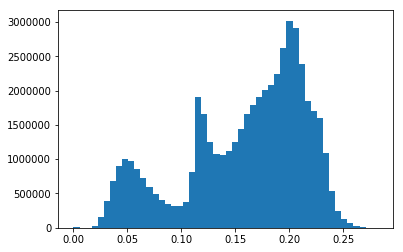

In [14]:
n,b,p = plt.hist(RMSD,bins=50)

### USR matrix

In [15]:
traj = mdtraj.load("dpap_nofit_50ps.xtc",top="dpap.pdb")
weights = np.ones(traj.n_atoms)

In [21]:
USR = np.zeros((10001,10001))

In [22]:
%%timeit
pyusr.pyUSRmat(traj.xyz,USR,weights,1)

1 loop, best of 3: 400 ms per loop


In [46]:
np.savetxt("usrmat_dpap_50ps",USR)

In [24]:
USR = USR[np.triu_indices(10001)]
USR.shape

(50015001,)

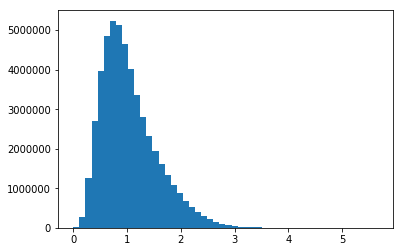

In [25]:
n1,b,p = plt.hist(USR,bins=50)

In [38]:
del USR

In [39]:
traj_fit = mdtraj.load("dpap_fit_50ps.xtc",top="dpap.pdb")

In [40]:
USR = np.zeros((10001,10001))

In [41]:
%%timeit
pyusr.pyUSRmat(traj.xyz,USR,weights,1)

1 loop, best of 3: 402 ms per loop


In [42]:
USR = USR[np.triu_indices(10001)]

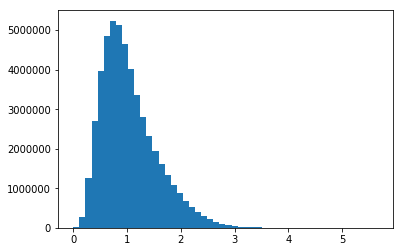

In [43]:
n2,b,p = plt.hist(USR,bins=50)

In [44]:
B = np.array([0.5*(b[i]+b[i+1]) for i in range(len(b)-1)])
B.shape

(50,)

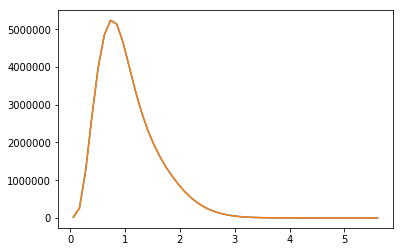

In [45]:
plt.plot(B,n1,B,n2)